In [21]:
import nltk, json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall, F1Score
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# nltk.download('punkt')

In [23]:
# Import data and labels
with open(r"Data/words.json", 'r') as f1:
    words = json.load(f1)
with open(r"Data/text.json", 'r') as f2:
    text = json.load(f2)
labels = np.load(r'Data/labels.npy')

In [24]:
# Dictionaries to store the word to index mappings and vice versa
word2idx = {o:i for i,o in enumerate(words)}
idx2word = {i:o for i,o in enumerate(words)}

# Looking up the mapping dictionary and assigning the index to the respective words
for i, sentence in enumerate(text):
    text[i] = [word2idx[word] if word in word2idx else 0 for word in sentence]
    
# Defining a function that either shortens sentences or pads sentences with 0 to a fixed length
def pad_input(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

text = pad_input(text, 50)

num_classes = len(np.unique(labels))

In [25]:
# Splitting dataset
train_text, test_text, train_label, test_label = train_test_split(text, labels, test_size=0.1, random_state=42)
train_text, valid_text, train_label, valid_label = train_test_split(train_text, train_label, test_size=0.1, random_state=42)

train_data = TensorDataset(torch.from_numpy(train_text), torch.from_numpy(train_label).long())
valid_data = TensorDataset(torch.from_numpy(valid_text), torch.from_numpy(valid_label).long())
test_data = TensorDataset(torch.from_numpy(test_text), torch.from_numpy(test_label).long())

In [26]:
class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(CNNTextClassifier, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        self.cnn = nn.Conv1d(in_channels=embed_dim, out_channels=embed_dim, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(embed_dim, num_classes)
    def forward(self, text):
        embedded=self.embedding(text).permute(1,0)
        conved=F.relu(self.cnn(embedded))
        conved=conved.mean(dim=1)
        outputs=self.fc(conved)
        proba=F.softmax(outputs, dim=0)
        return(proba)

In [27]:
cnn=CNNTextClassifier(vocab_size=len(word2idx), embed_dim=10, num_classes=num_classes)

# Training loop
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
save_params=[]
train_losses=[]
valid_losses=[]

num_epochs=20
for epoch in range(num_epochs):
    train_loss=0
    valid_loss=0
    
    #training loop
    cnn.train()
    for text, label in train_data:
        optimizer.zero_grad()
        pred_proba = cnn(text)
        loss = criterion(pred_proba, label)
        train_loss+=loss.item()
        loss.backward()
        optimizer.step()
    train_loss/=len(train_data)
    train_losses.append(train_loss)

    #calculating loss on validation dataset
    cnn.eval()
    with torch.no_grad():
        for text, label in valid_data:
            pred_proba=cnn(text)
            valid_loss += criterion(pred_proba, label).item()
    valid_loss/=len(valid_data)
    valid_losses.append(valid_loss)
    
    save_params.append(deepcopy(cnn.state_dict()))
    # print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

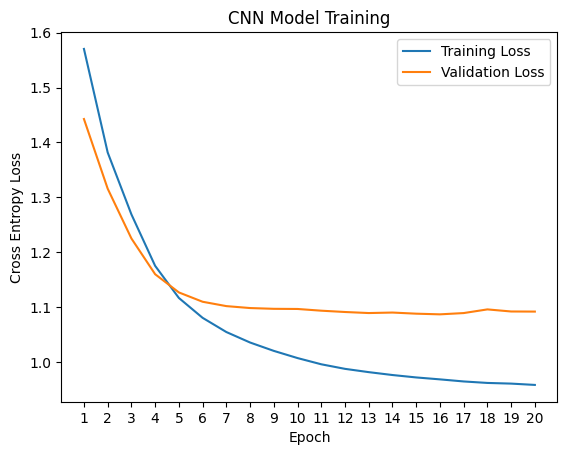

In [28]:
plt.plot(range(1,num_epochs+1), train_losses, linestyle = '-', label = 'Training Loss')
plt.plot(range(1,num_epochs+1), valid_losses, linestyle = '-', label = 'Validation Loss')
plt.legend()
plt.title("CNN Model Training")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.xticks(range(1,num_epochs+1))
plt.show()

In [29]:
best_model = CNNTextClassifier(vocab_size=len(word2idx), embed_dim=10, num_classes=num_classes)
best_model.load_state_dict(save_params[4])

accuracy = Accuracy(task='multiclass', num_classes=num_classes, average=None)
precision = Precision(task='multiclass', num_classes=num_classes, average=None)
recall = Recall(task='multiclass', num_classes=num_classes, average=None)
f1 = F1Score(task='multiclass', num_classes=num_classes, average=None)

test_outputs = torch.stack([best_model(features) for features, _ in test_data])
test_labels =  torch.stack([label for _, label in test_data])

classif_report = pd.DataFrame(
    {
        'Accuracy': accuracy(test_outputs, test_labels).tolist(),
        'Precision': precision(test_outputs, test_labels).tolist(),
        'Recall': recall(test_outputs, test_labels).tolist(),
        'F1_Score': f1(test_outputs, test_labels)
    }
)
classif_report.index = ['Class_'+str(x) for x in range(5)]

In [30]:
classif_report

,Accuracy,Precision,Recall,F1_Score
Class_0,0.734940,0.586538,0.734940,0.652406
Class_1,0.642105,0.685393,0.642105,0.663043
Class_2,0.786325,0.828829,0.786325,0.807018
Class_3,0.742857,0.917647,0.742857,0.821053
Class_4,0.910000,0.819820,0.910000,0.862559
